Analyze Student Usage
===

This notebook contains all the analysis in ["Safe Generative Chats in a WhatsApp Intelligent Tutoring System"](https://arxiv.org/abs/2407.04915).

Analyzes:
 - Initial December 2023 test with students (on the Research & Assessment WhatsApp line)
 - Later use (on the Rori Public WhatsApp line)

It is not intended to be executable (as it relies on proprietary code and data). Instead, it's a record of the analysis steps taken. Several cell outputs have been cleared, as they contain plain-text identifiers that could hypothetically be used to compromise student privacy (e.g. inferring usage behaviors).

In [1]:
import json
import os
from collections import Counter
from copy import copy, deepcopy
from datetime import datetime, timezone
from pathlib import Path

import dotenv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rori_orm
import scipy.stats
import statsmodels.stats.proportion
from rori_orm.django.content import models

In [2]:
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [3]:
matplotlib.rcParams["font.family"] = "serif"

In [4]:
assert dotenv.load_dotenv("../.env")

In [6]:
FIGURE_WIDTH_IN = 3.3492707
PAGE_WIDTH_IN = 7.031875

In [7]:
# based on a slack message, this is when I was told that the students would be using it "tomorrow"
experiment_start_datetime = datetime.fromisoformat("2023-12-13T11:15:00-08:00").astimezone(timezone.utc)
experiment_end_datetime = datetime.fromisoformat("2024-01-01").replace(tzinfo=timezone.utc)
f"{experiment_start_datetime} - {experiment_end_datetime}"

'2023-12-13 19:15:00+00:00 - 2024-01-01 00:00:00+00:00'

In [8]:
# based on a manual assessment of the data
actual_start_datetime = datetime.fromisoformat("2023-12-13T13:23:35+00:00")
actual_start_datetime

datetime.datetime(2023, 12, 13, 13, 23, 35, tzinfo=datetime.timezone.utc)

In [9]:
DATA_DIR = Path("../data")
assert DATA_DIR.exists()

In [10]:
FIGURES_DIR = DATA_DIR / "figures"

In [11]:
!du -h {DATA_DIR}/raw/*.jsonl

236K	../data/raw/gcp-dev.jsonl
 23M	../data/raw/supabase_staging.jsonl


In [ ]:
!head -n 2 {DATA_DIR}/raw/supabase_staging.jsonl

In [13]:
db = []
for line in open(DATA_DIR / "raw" / "supabase_staging.jsonl"):
    db.append(json.loads(line))
len(db)

12767

Basic gist for the December 2023 data:

 - Need all users on the research line.
 - Need all activity sessions with those users.
 - Need to exclude a few researcher users
 - Get all messages, generativechatmessagemetadata, etc. associated with those activity sessions.

In [14]:
tables = {}
for d in db:
    model = d["model"].split(".")[1]
    if model not in tables:
        tables[model] = []
    fields = dict(d["fields"])
    fields["pk"] = d["pk"]
    tables[model].append(fields)
len(tables)

6

In [15]:
tables.keys()

dict_keys(['user', 'activity', 'activitysession', 'message', 'generativechatmessagemetadata', 'messagefeedback'])

In [16]:
dfs = {}
for model, table in tables.items():
    dfs[model] = pd.DataFrame(table)
dfs.keys()

dict_keys(['user', 'activity', 'activitysession', 'message', 'generativechatmessagemetadata', 'messagefeedback'])

In [17]:
df = dfs["user"]
for dict_column in [
    "properties",
]:
    context_df = df[dict_column].apply(pd.Series)
    context_df = context_df.rename(columns=lambda col_name: dict_column + "_" + col_name)
    df = df.merge(context_df, left_index=True, right_index=True).drop(columns=dict_column)
dfs["user"] = df

In [ ]:
dfs["user"].sample(n=3)

In [19]:
dfs["user"].properties_turn_line_name.value_counts()

properties_turn_line_name
Rori Research and Assessment    135
Rori Demo                        37
Name: count, dtype: int64

In [ ]:
df = dfs["user"]
author_line_counts = df.properties_turn_author_id.value_counts()
author_line_counts[author_line_counts > 1]

In [21]:
assumed_researcher_author_ids = set(author_line_counts[author_line_counts > 1].index)
len(assumed_researcher_author_ids)

5

In [22]:
assumed_researcher_author_ids.add("snipped")
assumed_researcher_author_ids.add("snipped")
assumed_researcher_author_ids.add("snipped")
# these were identified in the subset spreadsheet
assumed_researcher_author_ids.update(["snipped", "snipped"])
len(assumed_researcher_author_ids)

10

In [23]:
student_users = set(df[df.properties_turn_line_name == "Rori Research and Assessment"].properties_turn_author_id)
print(len(student_users))
student_users -= assumed_researcher_author_ids
len(student_users)

133


124

In [24]:
user_df = df[
    (df.properties_turn_line_name == "Rori Research and Assessment")
    & (df.properties_turn_author_id.isin(student_users))
]
len(user_df)

124

In [25]:
session_df = dfs["activitysession"]
session_df.activity.value_counts()

activity
2    472
1     15
Name: count, dtype: int64

In [26]:
df = session_df
context_df = df[dict_column].apply(pd.Series)
context_df = context_df.rename(columns=lambda col_name: dict_column + "_" + col_name)
df = df.merge(context_df, left_index=True, right_index=True).drop(columns=dict_column)
session_df = df

In [27]:
dfs["activity"]

,created_at,updated_at,name,type,properties,pk
0,2023-11-20T00:09:25.685Z,2023-11-20T00:09:25.685Z,AskRori,generative_chat,{},1
1,2023-11-20T00:09:25.686Z,2023-11-20T00:09:25.686Z,TopicalConversation,generative_chat,{},2


In [28]:
session_df = pd.merge(session_df, user_df, how="inner", left_on="user", right_on="pk", suffixes=("", "_user"))
# keep only the TopicalConversations
session_df = session_df[session_df.activity == 2].reset_index(drop=True)
len(session_df)

287

In [ ]:
session_df.sample(n=3)

In [30]:
session_df.properties_topic.value_counts(dropna=False)

properties_topic
growth-mindset    287
Name: count, dtype: int64

In [31]:
# TODO what if any change was there between these API versions?
# (in hindsight: we probably deleted the safety branch, and that was a bad idea!!)
session_df.properties_api_version.value_counts(dropna=False)

properties_api_version
1.1.1+safety    162
1.1.0+safety    125
Name: count, dtype: int64

#### Sidebar: do any messages we care about receive multiple feedbacks?

Answer: no.

In [32]:
dfs["messagefeedback"].sample(n=1)

,message,created_at,feedback,pk
84,1128,2023-12-13T11:51:24.482Z,👍 ok,85


In [33]:
dfs["messagefeedback"].message.value_counts()

message
5354    2
2       1
5334    1
5310    1
5316    1
       ..
702     1
706     1
732     1
824     1
5948    1
Name: count, Length: 207, dtype: int64

In [ ]:
dfs["message"][dfs["message"].pk == 5354]

In [ ]:
session_df[session_df.pk == 410]

#### Sidebar: how many users provided feedback during red-teaming?

In [36]:
messages_with_feedback = set(dfs["messagefeedback"].message)
df = dfs["message"]
activity_sessions_with_feedback = set(df[df.pk.isin(messages_with_feedback)].activity_session)
df = dfs["activitysession"]
users_with_demoline_feedback = set(df[df.pk.isin(activity_sessions_with_feedback)].user)
len(users_with_demoline_feedback)

22

In [37]:
df = dfs["messagefeedback"]
nontest_messages_with_feedback = set(df[~df.feedback.str.contains("test", case=False, regex=False)].message)
len(nontest_messages_with_feedback)

152

In [38]:
df = dfs["message"]
activity_sessions_with_feedback = set(df[df.pk.isin(nontest_messages_with_feedback)].activity_session)
print(len(activity_sessions_with_feedback))
df = dfs["activitysession"]
users_with_demoline_feedback = set(df[df.pk.isin(activity_sessions_with_feedback)].user)
len(users_with_demoline_feedback)

57


18

In [39]:
df = dfs["messagefeedback"]
sdf = df[~df.feedback.str.contains("test", case=False, regex=False)]
positive_feedback = set(sdf[sdf.feedback.str.startswith("👍")].message)
negative_feedback = set(sdf[sdf.feedback.str.startswith("👎")].message)
len(positive_feedback), len(negative_feedback)

(113, 39)

## Merge messages to sessions

In [ ]:
df = pd.merge(
    session_df, dfs["message"], how="inner", left_on="pk", right_on="activity_session", suffixes=("_session", "")
)
df = pd.merge(
    df, dfs["generativechatmessagemetadata"], how="left", left_on="pk", right_on="message", suffixes=("", "_md")
)
df = pd.merge(df, dfs["messagefeedback"], how="left", left_on="pk", right_on="message", suffixes=("", "_feedback"))
df

In [41]:
session_feedback_list = []
session_feedback_score_list = []
for feedback_message_list in df.properties_session_feedback:
    session_feedback = None
    session_feedback_score = np.nan
    if type(feedback_message_list) != float:
        feedback_message_dict = feedback_message_list[-1]
        feedback_message = feedback_message_dict["feedback"].strip()
        if feedback_message == "⭐":
            session_feedback_score = 1
        elif feedback_message == "⭐⭐":
            session_feedback_score = 2
        elif feedback_message == "⭐⭐⭐":
            session_feedback_score = 3
        elif feedback_message == "⭐⭐⭐⭐":
            session_feedback_score = 4
        elif feedback_message == "⭐⭐⭐⭐⭐":
            session_feedback_score = 5
        session_feedback = feedback_message
    session_feedback_list.append(session_feedback)
    session_feedback_score_list.append(session_feedback_score)

df["session_feedback"] = session_feedback_list
df["session_feedback_score"] = session_feedback_score_list

In [42]:
df["created_at_dt"] = df.created_at.map(lambda d: datetime.fromisoformat(d[:-1]).replace(tzinfo=timezone.utc))
df["created_at_session_dt"] = df.created_at_session.map(
    lambda d: datetime.fromisoformat(d[:-1]).replace(tzinfo=timezone.utc)
)

In [43]:
df["in_experiment_period"] = (df.created_at_session_dt >= experiment_start_datetime) & (
    df.created_at_session_dt <= experiment_end_datetime
)
df.groupby("activity_session").in_experiment_period.first().value_counts()

in_experiment_period
True     242
False     45
Name: count, dtype: int64

In [44]:
OPENAI_MODERATION_CATEGORIES = [
    "self-harm/intent",
    "self-harm/instructions",
    "self-harm",
    "sexual/minors",
    "sexual",
    "violence",
    "violence/graphic",
    "harassment",
    "harassment/threatening",
    "hate",
    "hate/threatening",
]
scores = {category: [] for category in OPENAI_MODERATION_CATEGORIES}
for context in df.context:
    had_scores = False
    if type(context) == dict and "moderation_data" in context:
        moderation_data = context["moderation_data"]
        if "openai_moderation_result" in moderation_data:
            moderation_result = moderation_data["openai_moderation_result"]
            assert "category_scores" in moderation_result
            category_scores = moderation_result["category_scores"]
            for category in OPENAI_MODERATION_CATEGORIES:
                scores[category].append(category_scores[category])
            had_scores = True
    if not had_scores:
        for category in OPENAI_MODERATION_CATEGORIES:
            scores[category].append(np.nan)

# save scores to the dataframe
df = df.assign(**scores)

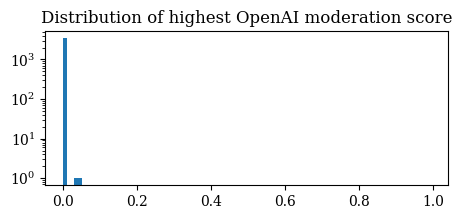

In [45]:
df["max_moderation_score"] = df[OPENAI_MODERATION_CATEGORIES].max(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(5.2, 2))

ax.hist(df.max_moderation_score, bins=np.arange(0, 1, 0.01), log=True)
ax.set_title("Distribution of highest OpenAI moderation score")

plt.show()

In [46]:
df.columns

Index(['activity', 'user', 'previous_activity_session', 'created_at_session',
       'updated_at', 'status', 'pk_session', 'properties_topic',
       'properties_feedback_count', 'properties_inbound_message_count',
       'properties_active_session_on_previous_topic', 'properties_api_version',
       'properties_session_feedback', 'created_at_user', 'updated_at_user',
       'current_activity_session', 'pk_user', 'properties_turn_line_id',
       'properties_turn_author_id', 'properties_turn_line_name',
       'properties_turn_line_number', 'activity_session', 'previous_message',
       'created_at', 'text', 'direction', 'bq_message_id', 'pk', 'message',
       'created_at_md', 'should_exclude', 'context', 'pk_md',
       'message_feedback', 'created_at_feedback', 'feedback', 'pk_feedback',
       'session_feedback', 'session_feedback_score', 'created_at_dt',
       'created_at_session_dt', 'in_experiment_period', 'self-harm/intent',
       'self-harm/instructions', 'self-harm', 'sexua

In [ ]:
df.iloc[4].T

In [48]:
# no message-level feedback, which is expected!
df.feedback.notna().value_counts()

feedback
False    4000
Name: count, dtype: int64

In [49]:
df.should_exclude.value_counts()

should_exclude
False    4000
Name: count, dtype: int64

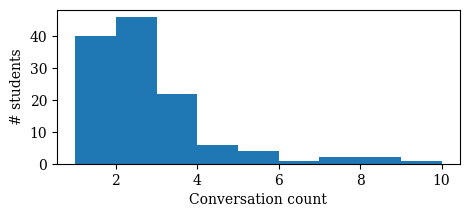

In [50]:
# distribution of conversation count
conversations = df.groupby("user").activity_session.nunique()
fig, ax = plt.subplots(1, 1, figsize=(5.2, 2))

ax.hist(conversations, bins=np.arange(1, conversations.max() + 2))
ax.set_xlabel("Conversation count")
ax.set_ylabel("# students")

plt.show()

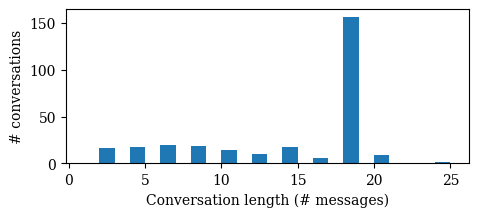

In [51]:
# distribution of conversation length
conversation_lengths = df.groupby("activity_session").message.nunique()
fig, ax = plt.subplots(1, 1, figsize=(5.2, 2))

ax.hist(conversation_lengths, bins=np.arange(1, conversation_lengths.max() + 2))
ax.set_xlabel("Conversation length (# messages)")
ax.set_ylabel("# conversations")

plt.show()

### Investigating session-level feedback

In [52]:
df.groupby("activity_session").properties_session_feedback.apply(lambda f: f.notna().any()).value_counts()

properties_session_feedback
True     165
False    122
Name: count, dtype: int64

In [ ]:
feedback = []
for session, group in df.groupby("activity_session"):
    if type(group.iloc[0].properties_session_feedback) == float:
        # janky way of filtering out NA values
        continue
    assert group.iloc[0].properties_session_feedback == group.iloc[1].properties_session_feedback
    feedback_list = group.iloc[0].properties_session_feedback
    # only 2 cases with multiple feedback, and the message doesn't change in either case
    feedback_dict = feedback_list[-1]
    feedback.append(feedback_dict)
feedback[0]

In [54]:
# this code was used above to create the column
for f in feedback:
    feedback_message = f["feedback"].strip()
    score = None
    if feedback_message == "⭐":
        score = 1
    elif feedback_message == "⭐⭐":
        score = 2
    elif feedback_message == "⭐⭐⭐":
        score = 3
    elif feedback_message == "⭐⭐⭐⭐":
        score = 4
    elif feedback_message == "⭐⭐⭐⭐⭐":
        score = 5
    if score is not None:
        print(score)
    break

In [55]:
df.groupby("activity_session").session_feedback_score.first().value_counts(dropna=False)

session_feedback_score
NaN    145
5.0    126
1.0      5
3.0      5
4.0      4
2.0      2
Name: count, dtype: int64

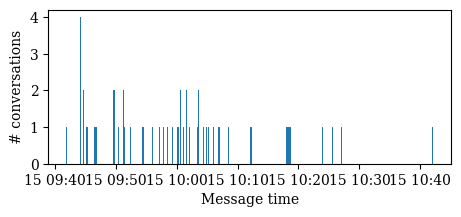

In [56]:
# creation date
fig, ax = plt.subplots(1, 1, figsize=(5.2, 2))
end_datetime = datetime(2024, 1, 1, tzinfo=timezone.utc)
start_datetime = datetime(2023, 12, 14, 12, 0, 0, tzinfo=timezone.utc)
sdf = df[(df.created_at_dt >= start_datetime) & (df.created_at_dt <= end_datetime)]
xs = sdf.groupby("activity_session").created_at_dt.min()
ax.hist(xs, log=False, bins=1000)
ax.set_xlabel("Message time")
ax.set_ylabel("# conversations")

plt.show()

In [ ]:
# sorted_df[[col for col in sorted_df.columns if col not in ["context", "properties_session_feedback"]]].to_csv(DATA_DIR / "derived" / "studentTest_dec2023.csv", index=False)
sorted_df = df.sort_values(["created_at_session", "message"]).reset_index(drop=True)
subset_columns = [
    "activity_session",
    "created_at_session",
    "user",
    "properties_turn_author_id",
    "created_at_user",
    "properties_inbound_message_count",
    "properties_api_version",
    "session_feedback",
    "session_feedback_score",
    "created_at",
    "previous_message",
    "message",
    "text",
    "direction",
    "should_exclude",
    "max_moderation_score",
] + OPENAI_MODERATION_CATEGORIES
sorted_df[subset_columns]

In [58]:
# cell used to create the files used for manual data inspection
# sorted_df.to_csv(DATA_DIR / "derived" / "studentTest_dec2023_full.csv", index=False)
# sorted_df[subset_columns].to_csv(DATA_DIR / "derived" / "studentTest_dec2023_subset.csv", index=False)

In [ ]:
df.groupby("activity_session").properties_turn_author_id.first().value_counts().head(10)

## Figures for the target period

In [60]:
sdf = df[df.created_at_dt >= actual_start_datetime]
len(sdf)

3722

In [61]:
# 252 conversations
sdf[(sdf.direction == "I") & (sdf.text != "")].groupby("activity_session").ngroups

252

In [62]:
sdf.groupby("activity_session").session_feedback_score.first().value_counts(dropna=False)

session_feedback_score
5.0    126
NaN    125
1.0      5
3.0      5
4.0      4
2.0      2
Name: count, dtype: int64

In [63]:
inbound_message_counts = sdf[(sdf.direction == "I") & (sdf.text != "")].groupby("activity_session").message.nunique()
inbound_message_counts.value_counts()

message
8     138
2      21
1      17
3      15
4      14
6      14
7      13
9      11
5       8
10      1
Name: count, dtype: int64

In [64]:
sdf.groupby("activity_session").properties_inbound_message_count.first().value_counts()

properties_inbound_message_count
9.0    155
3.0     19
5.0     17
2.0     17
4.0     16
1.0     15
7.0     13
6.0     10
8.0      5
Name: count, dtype: int64

In [65]:
# manual inspection of session 205 reveals it is a mistaken continuation of a previous conversation
# somehow, a bad interleaving associated an inbound message with a new activity session, BEFORE the initial message was sent
inbound_message_counts[inbound_message_counts == 10]

activity_session
205    10
Name: message, dtype: int64

In [ ]:
sdf.sort_values(by="max_moderation_score", ascending=False).head()[["text", "direction", "max_moderation_score"]]

In [67]:
# correct the message counts associated with session 205
inbound_message_counts[205] -= 1
inbound_message_counts[186] += 1

138.0


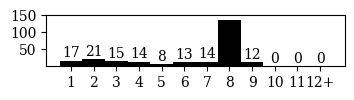

In [68]:
# session-level: distribution of conversation length
fig, ax = plt.subplots(1, 1, figsize=(FIGURE_WIDTH_IN, 0.8))

max_value = 14
bins = np.arange(1, max_value)
ns, bins, patches = ax.hist(inbound_message_counts, bins=bins, align="left", color="black")
xs = np.arange(1, max_value - 1)
ax.set_xticks(xs, labels=[f"{x}" if x != max_value - 2 else f"{x}+" for x in xs])
ax.set_yticks([50, 100, 150])
for x, n in zip(bins, ns):
    if n > 100:
        print(n)
    else:
        ax.text(x, n + 9, f"{n:.0f}", ha="center")
# ax.set_xlabel("Conversation length (student messages)")
# ax.set_ylabel("# convos")

fig.tight_layout(pad=0)
fig.savefig(FIGURES_DIR / "dec2023_conversation_length.pdf", dpi=150, pad_inches=0)
plt.show()

In [69]:
138 / 252, (138 + 12) / 252

(0.5476190476190477, 0.5952380952380952)

In [70]:
sdf.groupby("activity_session").session_feedback_score.first().value_counts(dropna=False)

session_feedback_score
5.0    126
NaN    125
1.0      5
3.0      5
4.0      4
2.0      2
Name: count, dtype: int64

In [71]:
ssdf = sdf[(sdf.direction == "I") & (sdf.text != "")]
low_df = ssdf[ssdf.session_feedback_score < 5]
print(len(low_df))
low_df.text.map(str.split).map(len).value_counts()

126


text
1    95
2    21
3     5
4     4
8     1
Name: count, dtype: int64

In [72]:
high_df = ssdf[ssdf.session_feedback_score == 5]
print(len(high_df))
high_df.text.map(str.split).map(len).value_counts()

992


text
1     649
3     117
2     103
4      48
5      21
6      18
9       9
7       8
10      5
12      4
8       3
11      3
16      2
13      1
23      1
Name: count, dtype: int64

In [73]:
low_messages = 126
low_single_word = 95
five_messages = 992
five_single_word = 649

cont = [[low_single_word, five_single_word], [low_messages, five_messages]]
scipy.stats.contingency.chi2_contingency(cont)
# note: this is precisely the same result as R's prop.test or chisq.test, as expected

Chi2ContingencyResult(statistic=0.8212951922328829, pvalue=0.36480175405434556, dof=1, expected_freq=array([[ 88.30504834, 655.69495166],
       [132.69495166, 985.30504834]]))

In [74]:
print(low_single_word / low_messages)
print(five_single_word / five_messages)

0.753968253968254
0.6542338709677419


In [75]:
scipy.stats.fisher_exact(cont, alternative="two-sided")

SignificanceResult(statistic=1.1524445422750507, pvalue=0.34198379732938966)

In [77]:
# why is this different?
# probably because it uses a different method with a less conservative approach: https://stats.stackexchange.com/a/544507/204430
statsmodels.stats.proportion.proportions_ztest([low_single_word, five_single_word], [low_messages, five_messages])

(2.235036638473821, 0.02541494349411181)

In [78]:
# verify: z-test and chi2 are equivalent
# https://rinterested.github.io/statistics/chi_square_same_as_z_test.html
statsmodels.stats.proportion.proportions_chisquare([low_single_word, five_single_word], [low_messages, five_messages])

(4.995388775320354,
 0.025414943494111872,
 (array([[ 95.,  31.],
         [649., 343.]]),
  array([[ 83.84973166,  42.15026834],
         [660.15026834, 331.84973166]])))

In [79]:
statsmodels.stats.proportion.proportions_ztest([low_single_word, low_messages], [five_single_word, five_messages])

(1.123473724135971, 0.26123635402809975)

In [80]:
statsmodels.stats.proportion.confint_proportions_2indep(
    low_single_word,
    low_messages,
    five_single_word,
    five_messages,
    method=None,
    compare="diff",
    alpha=0.05,
    correction=True,
)

(0.012796260970774256, 0.17315482608585153)

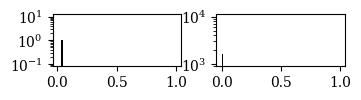

In [84]:
# message-level: distribution of max moderation scores
fig, axes = plt.subplots(1, 2, figsize=(FIGURE_WIDTH_IN, 0.8))

ssdf = sdf[sdf.direction == "I"]
ax = axes[0]
bins = np.arange(0.01, 1, 0.01)
ns, bins, patches = ax.hist(ssdf.max_moderation_score, bins=bins, color="black", log=True)

ssdf = sdf[sdf.direction == "O"]
ax = axes[1]
bins = np.arange(0, 1, 0.01)
ns, bins, patches = ax.hist(ssdf.max_moderation_score, bins=bins, color="black", log=True)

fig.tight_layout(pad=0)
# fig.savefig(FIGURES_DIR / "dec2023_conversation_length.pdf", dpi=150, pad_inches=0)
plt.show()

## Real usage data

In [86]:
start_of_year = datetime.fromisoformat("2024-01-01").replace(tzinfo=timezone.utc)
end_of_real_usage = datetime.fromisoformat("2024-05-01").replace(tzinfo=timezone.utc)

In [87]:
tc_activity = models.Activity.objects.filter(name="TopicalConversation").first()
tc_activity

<Activity: Activity object (2)>

In [88]:
pc_activity = models.Activity.objects.filter(name="PedagogicalChat").first()
pc_activity

<Activity: Activity object (3)>

In [89]:
activity_sessions = models.ActivitySession.objects.filter(activity=pc_activity, created_at__gt=start_of_year)
len(activity_sessions)

0

In [90]:
# to start: get line counts
activity_sessions = models.ActivitySession.objects.filter(
    activity=tc_activity, created_at__gt=start_of_year, created_at__lt=end_of_real_usage
).select_related("user")
len(activity_sessions)

8958

In [92]:
ds = []
for session in activity_sessions:
    d = dict(session.user.properties)
    d["user_id"] = session.user.id
    ds.append(d)
user_properties_df = pd.DataFrame(ds)

In [ ]:
user_properties_df

In [94]:
user_properties_df.turn_line_name.value_counts(dropna=False)

turn_line_name
Rori            5598
+12065906259    3157
Rori Schools     137
Rori Staging      49
Rori Demo         17
Name: count, dtype: int64

In [ ]:
user_properties_df.turn_line_number.value_counts(dropna=False)

In [ ]:
# based on this, valid analyses are only those on the rori lines
user_properties_df["turn_line_info"] = [
    (turn_line_name, turn_line_number)
    for turn_line_name, turn_line_number in zip(user_properties_df.turn_line_name, user_properties_df.turn_line_number)
]
user_properties_df.turn_line_info.value_counts(dropna=False)

In [ ]:
user_properties_df.turn_author_id[user_properties_df.turn_author_id.str.startswith("1")].value_counts()

In [128]:
s = datetime.now()
messages = (
    models.GenerativeChatMessageMetadata.objects.filter(
        message__activity_session__activity__id=2,
        message__activity_session__user__properties__turn_line_number="+12065906259",
        message__created_at__gt=start_of_year,
        message__created_at__lt=end_of_real_usage,
    )
    .select_related("message", "message__activity_session")
    .all()
)
print(len(messages))
print(f"Query took {datetime.now() - s}")

126278
Query took 0:00:40.680344


In [142]:
inbound_message_session_ids = [
    message.message.activity_session.id
    for message in messages
    if message.message.direction == models.Message.MessageDirection.INBOUND
]
inwild_inbound_message_counts = Counter(inbound_message_session_ids)
inwild_inbound_message_counts.most_common(5)

[(41664, 23), (16030, 21), (22214, 20), (36477, 20), (12715, 19)]

2591.0


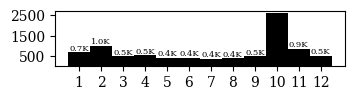

In [143]:
# session-level: distribution of conversation lengths
fig, ax = plt.subplots(1, 1, figsize=(FIGURE_WIDTH_IN, 0.8))

max_length = 14
counts = list(inwild_inbound_message_counts.values())
counts = [min(count, 12) for count in counts]

bins = np.arange(1, max_length)
ns, bins, patches = ax.hist(counts, bins=bins, align="left", color="black")
xs = np.arange(1, max_length - 1)
ax.set_xticks(xs)
ax.set_yticks([500, 1500, 2500])
for x, n in zip(bins, ns):
    if n > 1500:
        print(n)
    else:
        ax.text(x, n + 100, f"{n/1000:.1f}K", ha="center", size=6)

fig.tight_layout(pad=0)
fig.savefig(FIGURES_DIR / "inwild_conversation_length.pdf", dpi=150, pad_inches=0)
plt.show()

138.0
2591.0


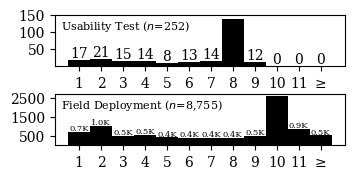

In [144]:
# session-level: distribution of conversation lengths
fig, axes = plt.subplots(2, 1, figsize=(FIGURE_WIDTH_IN, 1.6))

max_value = 14
label_height = 0.94

ax = axes[0]
bins = np.arange(1, max_value)
ns, bins, patches = ax.hist(inbound_message_counts, bins=bins, align="left", color="black")
xs = np.arange(1, max_value - 1)
ax.set_xticks(xs, labels=[f"{x}" if x != max_value - 2 else f"≥" for x in xs])
ax.set_yticks([50, 100, 150])
for x, n in zip(bins, ns):
    if n > 100:
        print(n)
    else:
        ax.text(x, n + 9, f"{n:.0f}", ha="center")
ax.text(
    0.02,
    label_height,
    f"Usability Test ($n$={len(inbound_message_counts)})",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    size=8,
)
dec2023_ns = ns


ax = axes[1]
counts = list(inwild_inbound_message_counts.values())
counts = [min(count, max_value - 2) for count in counts]

bins = np.arange(1, max_length)
ns, bins, patches = ax.hist(counts, bins=bins, align="left", color="black")
xs = np.arange(1, max_length - 1)
ax.set_xticks(xs, labels=[f"{x}" if x != max_value - 2 else f"≥" for x in xs])
ax.set_yticks([500, 1500, 2500])
for x, n in zip(bins, ns):
    if n > 1500:
        print(n)
    else:
        ax.text(x, n + 100, f"{n/1000:.1f}K", ha="center", size=6)
ax.text(
    0.02,
    label_height,
    f"Field Deployment ($n$={len(counts):,})",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    size=8,
)
inwild_ns = ns

# ax.xaxis.majorTicks[-1].label1._fontproperties._size -= 2

fig.tight_layout(pad=0, h_pad=0.2)
fig.savefig(FIGURES_DIR / "both_conversation_length.pdf", dpi=150, pad_inches=0)
plt.show()

In [145]:
# higher conversational attrition in the wild
len(counts), 2641 / len(counts)

(8755, 0.3016561964591662)

In [146]:
finished_conversation_count = sum(dec2023_ns[7:])
finished_conversation_count, finished_conversation_count / len(inbound_message_counts)

(150.0, 0.5952380952380952)

In [147]:
finished_conversation_count = sum(inwild_ns[9:])
finished_conversation_count, finished_conversation_count / len(inwild_inbound_message_counts)

(3968.0, 0.4532267275842376)

In [148]:
inwild_ns[9]

2591.0

In [149]:
min([message.message.created_at for message in messages]), max([message.message.created_at for message in messages])

(datetime.datetime(2024, 2, 13, 12, 36, 48, 49082, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 4, 30, 23, 59, 28, 381628, tzinfo=datetime.timezone.utc))

In [150]:
ds = []
for message in messages:
    d = {
        "id": message.message.id,
        "direction": message.message.direction,
        "activity_session": message.message.activity_session.id,
        "user": message.message.activity_session.user_id,
    }
    if "moderation_data" in message.context:
        moderation_data = message.context["moderation_data"]
        openai_moderation_result = moderation_data["openai_moderation_result"]
        d.update(**openai_moderation_result["category_scores"])
    ds.append(d)
wild_df = pd.DataFrame(ds)
wild_df.shape

(126278, 15)

In [151]:
# counts for messages, users, and sessions


def latex_counts(*counts):
    return " & ".join([f"{count:,}" for count in counts])


latex_counts(wild_df.user.nunique(), wild_df.activity_session.nunique(), wild_df.id.nunique())

'8,168 & 8,755 & 126,278'

In [152]:
latex_counts(sdf.user.nunique(), sdf.activity_session.nunique(), sdf.message.nunique())

'109 & 267 & 3,722'

In [153]:
wild_df = wild_df.dropna(subset="hate").reset_index(drop=True)
wild_df.shape

(108722, 15)

In [154]:
wild_df["max_moderation_score"] = wild_df[OPENAI_MODERATION_CATEGORIES].max(axis=1)

In [155]:
dec_df = sdf[sdf.max_moderation_score.notna()]
dec_df.shape

(3188, 54)

In [156]:
wild_maxes = wild_df[wild_df.direction == "I"].max_moderation_score
wild_maxes.median(), wild_maxes.max(), wild_maxes.quantile(0.99)

(0.0006972992268856615, 0.9888346791267395, 0.029710594564676285)

In [157]:
dec_maxes = dec_df[dec_df.direction == "I"].max_moderation_score
dec_maxes.median(), dec_maxes.max(), dec_maxes.quantile(0.99)

(4.3327872845111415e-05, 0.045291077345609665, 0.00213855187874287)

In [158]:
for direction in ["O", "I"]:
    for name, source_df in (["Usability Test", dec_df], ["Field Deployment", wild_df]):
        maxes = source_df[source_df.direction == direction].max_moderation_score
        print(
            f"{name:>20} {direction} {maxes.median():.5f} {maxes.max():.5f} {maxes.quantile(0.99):.5f} {(maxes >= 0.5).sum()} / {len(maxes)}"
        )

      Usability Test O 0.00000 0.00989 0.00044 0 / 1594
    Field Deployment O 0.00016 0.04402 0.00265 0 / 54338
      Usability Test I 0.00004 0.04529 0.00214 0 / 1594
    Field Deployment I 0.00070 0.98883 0.02971 42 / 54384


In [161]:
q = 0.99
for direction_identifier, direction in zip(["Student", "GPT-3.5"], ["I", "O"]):
    contents = [direction_identifier]
    for name, source_df in (["Usability Test", dec_df], ["Field Deployment", wild_df]):
        maxes = source_df[source_df.direction == direction].max_moderation_score
        contents.extend([f"{maxes.quantile(q):.3f}", f"{maxes.max():.3f}"])
    print(" & ".join(contents))

Student & 0.002 & 0.045 & 0.030 & 0.989
GPT-3.5 & 0.000 & 0.010 & 0.003 & 0.044


In [173]:
q = 0.99
swild_df = wild_df[wild_df.direction == "I"]
print(len(swild_df))
for column in sorted(
    OPENAI_MODERATION_CATEGORIES,
    key=lambda column: ((swild_df[column] >= 0.5).sum(), (swild_df[column] >= 0.1).sum(), swild_df[column].max()),
    reverse=True,
):
    scores = swild_df[column]
    contents = [column.capitalize()]
    contents.extend(
        [
            f"{scores.quantile(q):.3f}",
            f"{scores.max():.3f}",
            f"{(scores >= 0.1).sum()}",
            f"{(scores >= 0.5).sum()}",
        ]
    )
    print(" & ".join(contents) + " \\\\")

54384
Harassment & 0.011 & 0.989 & 141 & 36 \\
Sexual & 0.012 & 0.914 & 28 & 5 \\
Hate & 0.002 & 0.524 & 3 & 1 \\
Violence & 0.001 & 0.959 & 2 & 1 \\
Self-harm/intent & 0.001 & 0.743 & 1 & 1 \\
Self-harm & 0.001 & 0.531 & 1 & 1 \\
Harassment/threatening & 0.000 & 0.451 & 1 & 0 \\
Hate/threatening & 0.000 & 0.087 & 0 & 0 \\
Violence/graphic & 0.000 & 0.081 & 0 & 0 \\
Self-harm/instructions & 0.000 & 0.072 & 0 & 0 \\
Sexual/minors & 0.007 & 0.024 & 0 & 0 \\


In [185]:
dec_df.created_at.max(), dec_df.created_at.sort_values(ascending=True).iloc[
    int(len(dec_df) * 0.95)
], dec_df.created_at.min()

('2024-01-19T13:39:32.327Z',
 '2023-12-15T10:24:45.354Z',
 '2023-12-13T13:24:06.382Z')

In [187]:
(dec_df.created_at >= "2023-12-16T00:00:00.000Z").sum()

16

In [ ]:
dec_df[dec_df.direction == "O"].sort_values("max_moderation_score", ascending=False).head(5)[
    ["text", "max_moderation_score"] + OPENAI_MODERATION_CATEGORIES
]

In [194]:
dec_df[dec_df.direction == "O"].sort_values("max_moderation_score", ascending=False).head(5)[
    ["text", "max_moderation_score"] + OPENAI_MODERATION_CATEGORIES
].iloc[0].text

'Oh, it seems like you might not understand the question. Let me rephrase it. Do you think that being smart is something that you can choose to be, rather than something that you are born with?'

In [ ]:
dec_df[dec_df.direction == "I"].sort_values("max_moderation_score", ascending=False).head(5)[
    ["text", "max_moderation_score"] + OPENAI_MODERATION_CATEGORIES
].iloc[0]

In [203]:
scores = wild_df[wild_df.direction == "I"].max_moderation_score
f"{(scores >= 0.1).sum() / len(scores):.2%}", f"{(scores >= 0.5).sum() / len(scores):.2%}"

('0.31%', '0.08%')

In [209]:
2 / 2500, 8 / 10000

(0.0008, 0.0008)

### Investigating responses to flagged student messages

In [233]:
adf = wild_df[(wild_df.direction == "I") & (wild_df.max_moderation_score < 0.5) & (wild_df.max_moderation_score >= 0.1)]
almost_flagged_session_ids = set(adf.activity_session)
len(almost_flagged_session_ids)

58

In [ ]:
adf = wild_df[(wild_df.direction == "I") & (wild_df.max_moderation_score >= 0.5)]
flagged_session_ids = set(adf.activity_session)
adf.head(10)

In [235]:
len(flagged_session_ids)

26

In [237]:
almost_flagged_session_ids = almost_flagged_session_ids - flagged_session_ids
len(almost_flagged_session_ids)

49

In [221]:
conversations = {activity_session: [] for activity_session in flagged_session_ids}
for message in messages:
    if message.message.activity_session_id in conversations:
        conversations[message.message.activity_session_id].append(message)

In [ ]:
for i, session_id in enumerate(conversations.keys()):
    print(f"START OF CONVERSATION {i} / {len(conversations)}")
    for message in conversations[session_id]:
        if "moderation_data" in message.context:
            moderation_data = message.context["moderation_data"]
            openai_moderation_result = moderation_data["openai_moderation_result"]
            max_score = max(openai_moderation_result["category_scores"].values())
            if max_score >= 0.5:
                print(f"******* {max_score:.5f}")
        print(message.message.direction)
        print(message.message.text)
    print("END OF CONVERSATION")
    break

In [240]:
almost_flagged_conversations = {activity_session: [] for activity_session in almost_flagged_session_ids}
for message in messages:
    if message.message.activity_session_id in almost_flagged_conversations:
        almost_flagged_conversations[message.message.activity_session_id].append(message)

In [ ]:
to_print = 0
for i, session_id in enumerate(almost_flagged_conversations.keys()):
    print(f"START OF CONVERSATION {i+1} / {len(almost_flagged_conversations)}")
    for message in almost_flagged_conversations[session_id]:
        if "moderation_data" in message.context:
            moderation_data = message.context["moderation_data"]
            openai_moderation_result = moderation_data["openai_moderation_result"]
            max_score = max(openai_moderation_result["category_scores"].values())
            if max_score >= 0.1:
                print(f"******* {max_score:.5f}")
                to_print += 3
        if to_print > 0:
            print(message.message.direction)
            print(message.message.text)
            to_print -= 1
    print("END OF CONVERSATION")